In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [50]:
!pip install fastparquet


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
# Method 1: Using raw string and forward slashes
data = pd.read_parquet(r'Datathon/sentiment/train-00000-of-00001.parquet')

# OR Method 2: Using os.path.join (recommended)
file_path = os.path.join('Datathon', 'sentiment', 'train-00000-of-00001.parquet')
data = pd.read_parquet(file_path)

# Verify the data was loaded
print("Data shape:", data.shape)
print("\nFirst few rows:")
print(data.head(20))

Data shape: (416809, 2)

First few rows:
                                                 text  label
0   i feel awful about it too because it s my job ...      0
1                               im alone i feel awful      0
2   ive probably mentioned this before but i reall...      1
3            i was feeling a little low few days back      0
4   i beleive that i am much more sensitive to oth...      2
5   i find myself frustrated with christians becau...      2
6   i am one of those people who feels like going ...      1
7   i feel especially pleased about this as this h...      1
8   i was struggling with these awful feelings and...      1
9     i feel so enraged but helpless at the same time      3
10                    i said feeling a bit rebellious      3
11  i also feel disillusioned that someone who cla...      0
12  i mean is on this stupid trip of making the gr...      1
13  i woke up feeling particularly vile tried to i...      3
14  i could feel the vile moth burrowing its

In [52]:
emotion_map = {0:'sadness', 1:'Joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
data['emotion'] = data['label'].map(emotion_map)

print(data[['text','emotion']].head())


                                                text  emotion
0  i feel awful about it too because it s my job ...  sadness
1                              im alone i feel awful  sadness
2  ive probably mentioned this before but i reall...      Joy
3           i was feeling a little low few days back  sadness
4  i beleive that i am much more sensitive to oth...     love


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = data['text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [54]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

model = MultinomialNB()
model.fit(X_train_vectorized, y_train)

y_pred = model.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred, target_names=emotion_map.values()))


Accuracy: 0.84
              precision    recall  f1-score   support

     sadness       0.84      0.95      0.89     24504
         Joy       0.78      0.97      0.87     28247
        love       0.96      0.43      0.59      6853
       anger       0.94      0.77      0.84     11339
        fear       0.90      0.69      0.78      9376
    surprise       0.98      0.24      0.38      3043

    accuracy                           0.84     83362
   macro avg       0.90      0.68      0.73     83362
weighted avg       0.85      0.84      0.82     83362



In [55]:
!pip install nltk


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Create dictionaries to store sentiment words for each emotion
emotion_sentiment_words = {emotion: [] for emotion in emotion_map.values()}

# Analyze words for each emotion
for text, label in zip(X_train, y_train):
    emotion = emotion_map[label]
    words = text.lower().split()
    
    # Filter for words with strong sentiment scores
    for word in set(words):  # Using set to avoid duplicates
        sentiment_score = sia.polarity_scores(word)
        compound_score = abs(sentiment_score['compound'])  # Take absolute value for strength
        if compound_score > 0.5:  # Only keep words with strong sentiment
            emotion_sentiment_words[emotion].append((word, compound_score))

# Print top sentiment words for each emotion
for emotion in emotion_map.values():
    # Sort by sentiment strength and get unique words
    unique_words = sorted(set(emotion_sentiment_words[emotion]), key=lambda x: x[1], reverse=True)
    print(f"\nTop sentiment words for {emotion}:")
    for word, score in unique_words[:10]:
        print(f"{word}: {score:.3f}")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


KeyboardInterrupt: 

In [45]:
emotion_sentiment_words = {emotion: [] for emotion in emotion_map.values()}

In [46]:
for text, label in zip(X_train, y_train):
    emotion = emotion_map[label]
    words = text.lower().split()
    
    for word in set(words):  # Using set removes duplicates
        sentiment_score = sia.polarity_scores(word)
        compound_score = abs(sentiment_score['compound'])
        if compound_score > 0.5:  # Only strong sentiment words
            emotion_sentiment_words[emotion].append((word, compound_score))

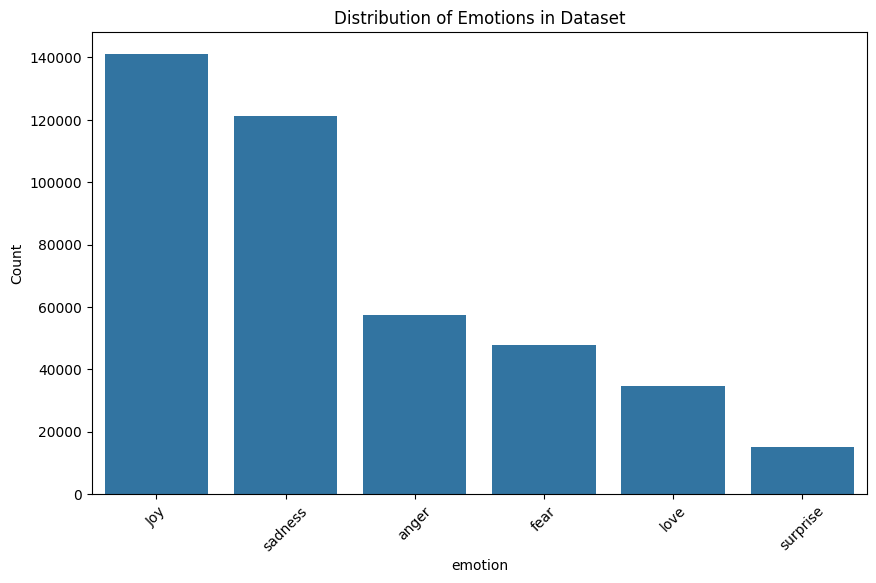

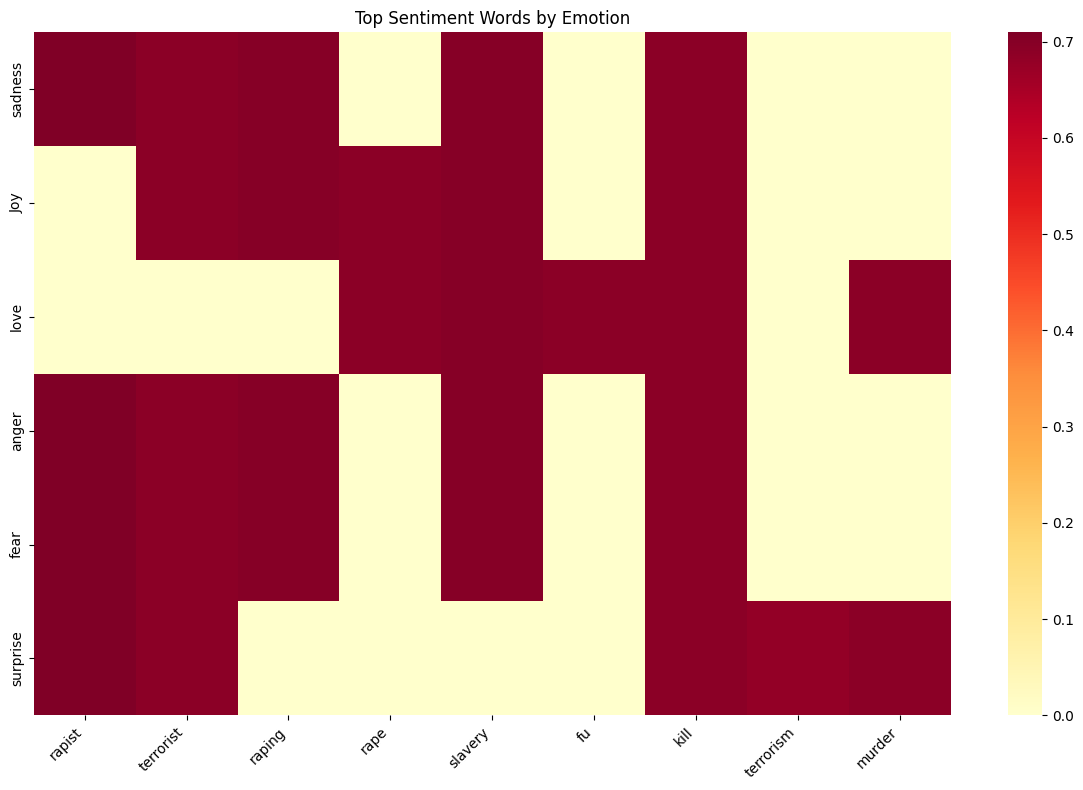

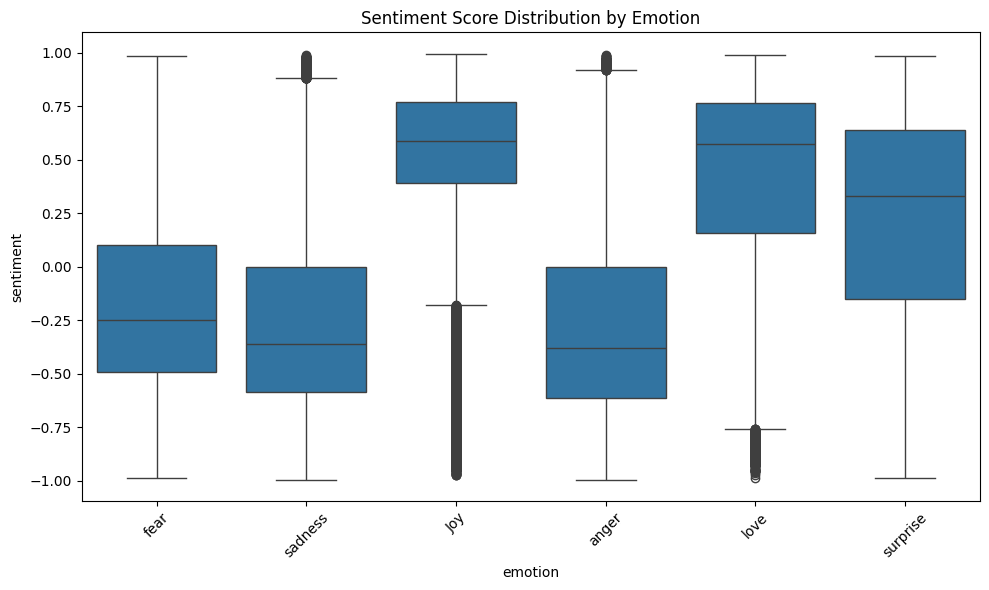

ModuleNotFoundError: No module named 'wordcloud'

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Emotion Distribution Plot
plt.figure(figsize=(10, 6))
emotion_counts = data['emotion'].value_counts()
sns.barplot(x=emotion_counts.index, y=emotion_counts.values)
plt.title('Distribution of Emotions in Dataset')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

# 2. Top Sentiment Words Heatmap
def get_top_n_words(emotion_sentiment_words, n=5):
    emotion_top_words = {}
    for emotion, words in emotion_sentiment_words.items():
        # Get unique words sorted by sentiment strength
        unique_words = sorted(set(words), key=lambda x: x[1], reverse=True)
        # Get top n words and their scores
        top_words = unique_words[:n]
        emotion_top_words[emotion] = dict(top_words)
    return emotion_top_words

top_words_dict = get_top_n_words(emotion_sentiment_words, n=5)
emotions = list(top_words_dict.keys())
words = list(set([word for emotion_words in top_words_dict.values() for word in emotion_words.keys()]))

# Create matrix for heatmap
heatmap_data = np.zeros((len(emotions), len(words)))
for i, emotion in enumerate(emotions):
    for j, word in enumerate(words):
        heatmap_data[i, j] = top_words_dict[emotion].get(word, 0)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, xticklabels=words, yticklabels=emotions, cmap='YlOrRd')
plt.title('Top Sentiment Words by Emotion')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Average Sentiment Score by Emotion
emotion_avg_sentiment = []
for text, label in zip(X_train, y_train):
    emotion = emotion_map[label]
    sentiment = sia.polarity_scores(text)['compound']
    emotion_avg_sentiment.append((emotion, sentiment))

sentiment_df = pd.DataFrame(emotion_avg_sentiment, columns=['emotion', 'sentiment'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='emotion', y='sentiment', data=sentiment_df)
plt.title('Sentiment Score Distribution by Emotion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Word Cloud for each emotion (if you want to visualize word frequencies)
from wordcloud import WordCloud

plt.figure(figsize=(20, 12))
for i, (emotion, words) in enumerate(emotion_sentiment_words.items(), 1):
    word_freq = dict(words)  # Convert list of tuples to dictionary
    plt.subplot(2, 3, i)
    wordcloud = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - {emotion}')
    plt.axis('off')
plt.tight_layout()
plt.show()